In [1]:
# Interactive map libraries
from ipyleaflet import Map, basemaps, Marker, basemap_to_tiles, TileLayer, LayersControl
from ipywidgets import Output, VBox, Button

# NDVI time series libraries
import planetary_computer
from pystac_client import Client
import stackstac
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Output widget for displaying coordinates
output = Output()

# Store the coordinates when clicking
coords_onclick = []
marker_layers = []  # Store markers so we can remove them

esri_satellite = TileLayer(
    url="https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attribution="Esri World Imagery",
    name="Esri Satellite")
# Labels overlay (Esri Reference Layer)
esri_labels = TileLayer(
    url="https://services.arcgisonline.com/ArcGIS/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}",
    attribution="Esri Labels",
    name="Labels",
    opacity=1.0)

# Initialize map
m = Map(
    center=(20, 0),  # Lat, Lon
    zoom=3,
    scroll_wheel_zoom=True
)

# Add to map
m.add_layer(esri_satellite)
m.add_layer(esri_labels)
m.add_control(LayersControl(position='topright'))

# Click handler function
def handle_click(**kwargs):
    if kwargs.get('type') == 'click':
        # Keep coordinates
        latlon = kwargs.get('coordinates')
        coords_onclick.append(latlon)  # Save to list
        
        # Add marker and keep
        marker = Marker(location=latlon, draggable=False)
        marker_layers.append(marker)
        m.add_layer(marker)
    return

# Attach click event
m.on_interaction(handle_click)

# Reset button
reset_button = Button(description="Reset Markers", button_style="danger")
def reset_clicked_coords(btn):
    # Clear stored coordinates and remove markers
    coords_onclick.clear()
    for marker in marker_layers:
        m.remove_layer(marker)
    marker_layers.clear()
    with output:
        print("All coordinates were erased. All markers were cleared.")
    return

reset_button.on_click(reset_clicked_coords)

# Display
VBox([m, reset_button, output])

In [11]:
coords_onclick

[[41.591526910556226, 2.2731040518651073],
 [41.61229370532903, 2.283303382586302],
 [41.612028996125765, 2.2831746338551455]]

## NDVI time series

In [4]:
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)
        end_time = time.time()    # Record end time
        print(f"Function '{func.__name__}' executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

In [5]:
def epsg_str_to_int(epsg_str: str = 'EPSG:4362') -> int:
    """
    Converts the EPSG from string to integer
    
    Args:
        epsg_str (str): EPSG of the form EPSG:<code>
    
    Returns:
        int
    """
    return int(epsg_str.split(':')[1])

In the `main` function it would make sense to modify the `cloud_cover` and the buffer size of `buffered_geom`.  The buffer size says how big the area of the selected coordinates will be.

In [6]:
@timing_decorator
def main(start_date: str = "yyyy-mm-dd", end_date: str = "yyyy-mm-dd", coords: tuple = (float, float)) -> tuple:
    """
    Args:
        start_date (str): start date
        end_date (str): end date
        coords (tuple): latitude (float), longitude (float)
    
    Returns:
        tuple: ndvi_mean (np.array), ndvi_time (np.array)
    """
    # # Coordinates and time range
    lat, lon = coords # Replace with your coordinate

    # Create a GeoDataFrame for your point
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")
    # Connect to MPC STAC API
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Search Sentinel-2 Level 2A imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=gdf.geometry[0],
        datetime=f"{start_date}/{end_date}",
        query={"eo:cloud_cover": {"lt": 30}},
    )
    items = list(search.items())
    
    # Sign the items for Planetary Computer access
    signed_items = [planetary_computer.sign(item) for item in items]  # take first for simplicity
    
    # Derive target epsg as integer
    epsg_int = epsg_str_to_int(items[0].properties['proj:code'])
    buffered_geom = gdf.to_crs(epsg=epsg_int).buffer(1).to_crs(epsg=4326) # the buffer size can be modified as you wish
    
    stack = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],  # Red and NIR bands for NDVI
    epsg=epsg_int, 
    resolution=10,
    bounds_latlon=buffered_geom.total_bounds,
    chunksize=4096,
    )

    # Select Red and NIR
    red = stack.sel(band="B04").astype("float32")
    nir = stack.sel(band="B08").astype("float32")

    ndvi = (nir - red) / (nir + red)
    ndvi_mean_xr = ndvi.mean(dim=["x", "y"]).compute()  # average at that location
    # Get time and ndvi values
    # ndvi_mean = ndvi_mean_xr.values
    # ndvi_time = ndvi_mean_xr.time.values
    ndvi_mean = ndvi_mean_xr.to_series()
    
    return ndvi_mean#, ndvi_time

Below you can play with the `start_date` and `end_date`. If you have a list of coordinates, you can also select the specific coordinate you want by changing the `index`.  

In [12]:
# Run example
# coords = <lat>, <lon>  # Replace with your coordinate
index = 1
coords = tuple(coords_onclick[index])
start_date = "2016-01-01" # Define
end_date = "2025-12-30"

ndvi_mean = main(start_date, end_date, coords)

Function 'main' executed in 33.8382 seconds


In [13]:
# Fill NaNs (interpolate) and smooth
ndvi_mean_filled = ndvi_mean.interpolate(method='time')
ndvi_mean_smoothed = ndvi_mean_filled.rolling(window=10, center=True).mean()

In [14]:
# Derive numpy arrays
ndvi_original = ndvi_mean.values # Original NDVI
ndvi_smoothed = ndvi_mean_smoothed.values # Smoothed NDVI
ndvi_time = ndvi_mean.index.to_numpy() # Datetimes

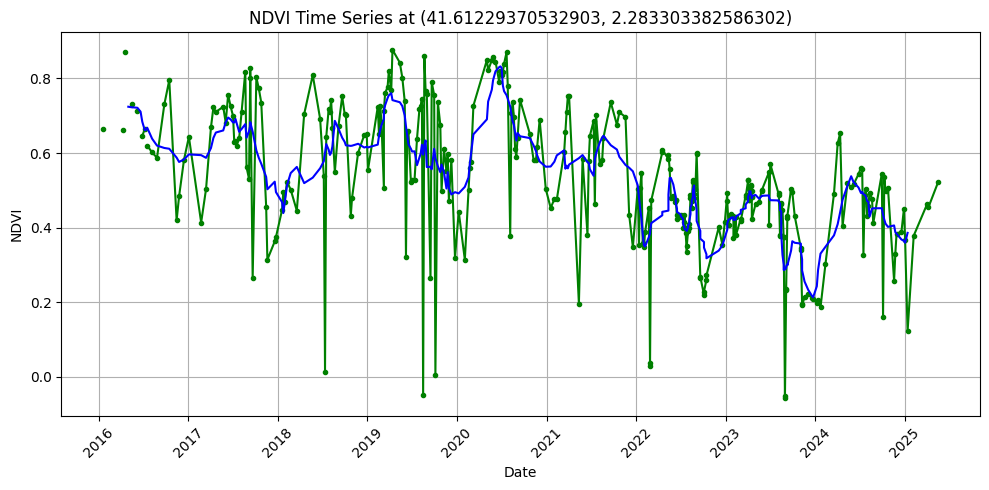

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(ndvi_time, ndvi_original, marker='.', linestyle='-', color='green') # Original NDVI
plt.plot(ndvi_time, ndvi_smoothed, marker='', linestyle='-', color='blue') # Smoothed NDVI
plt.title("NDVI Time Series at ({}, {})".format(coords[0], coords[1]))
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Draft

In the code below you can execute each step of the above function interactively.

In [83]:
# Coordinates and time range
lat, lon = 2.32738, 41.61884  # Replace with your coordinate
start_date = "2020-01-01"
end_date = "2025-12-30"

# Create a GeoDataFrame for your point
gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")

In [84]:
# bounds_modified = np.array([gdf.total_bounds[0] - 0.01, gdf.total_bounds[1] - 0.01, gdf.total_bounds[2] + 0.01, gdf.total_bounds[3] + 0.01])

In [85]:
# gdf.total_bounds

In [86]:
# Connect to MPC STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search Sentinel-2 Level 2A imagery
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=gdf.geometry[0],
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 40}},
)

items = list(search.items())
print(f"Found {len(items)} items")

Found 202 items


In [87]:
# Sign the items for Planetary Computer access
signed_items = [planetary_computer.sign(item) for item in items]  # take first for simplicity

In [88]:
# for i in signed_items:
#     print(i.properties['proj:code'])

In [89]:
buffered_geom = gdf.to_crs(epsg=32610).buffer(1).to_crs(epsg=4326)
buffered_geom, buffered_geom.total_bounds

(0    POLYGON ((41.61883 2.32738, 41.61883 2.32738, ...
 dtype: geometry,
 array([41.61883133,  2.32737128, 41.61884867,  2.32738872]))

In [90]:
# bounds_modified = np.array([gdf.total_bounds[0] - 0.01, gdf.total_bounds[1] - 0.01, gdf.total_bounds[2] + 0.01, gdf.total_bounds[3] + 0.01])
# bounds_modified, gdf.total_bounds

In [91]:
# Load data using stackstac
stack = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],  # Red and NIR bands for NDVI
    epsg=32610,
    resolution=10,
    bounds_latlon=buffered_geom.total_bounds,
    chunksize=4096,
)

# Select Red and NIR
red = stack.sel(band="B04").astype("float32")
nir = stack.sel(band="B08").astype("float32")

In [92]:
ndvi = (nir - red) / (nir + red)
ndvi_mean_xr = ndvi.mean(dim=["x", "y"]).compute()  # average at that location
# print("NDVI:", ndvi_mean)

In [93]:
# ndvi_mean_xr.values

In [94]:
# ndvi_mean_xr.time.values

In [95]:
# Get time and ndvi values
ndvi_mean = ndvi_mean_xr.values
ndvi_time = ndvi_mean_xr.time.values

In [ ]:
# ndvi.isel(time=10).plot(cmap="YlGn")
# plt.title("NDVI")
# plt.show()